In [21]:
import math
import plotly.express as px
import plotly.graph_objects as go

In this workbook, I am going to set up my calculations for the major project. 
What I want to achieve ultimately is a tool for the analysis of SFRC-RC beams.
I want to use the following tools:
- Mobasher's theory for M-phi diagrams of SFRC-RC beams
- PyNite for the statics
- My theory for the shear check.

I also have to make sure that I include test functions for the functions I write.


In [2]:
#input values
# Concrete material parameters
fc= 28.1 #MPa
daggmax= 12.5 #mm bar diameter

# Reinforcement steel parameters
fy= 565 #MPa
As= 1005  #mm2
ns= 5 #number of bars
phibar= 16 #mm bar diameter

# Steel fiber parameters
rhof= 1 #fiber bond efficiency
Vf= 0.0075 #fiber volume fraction
df= 0.55 #mm fiber equivalent diameter
lf= 35 #mm fiber length

# Sectional geometry
b= 150 #mm
d= 251 #mm
h= 300 #mm

# Loading conditions
#a= #mm
#lspan = #mm

In [3]:
Ec = 57000/12 * fc**(1/2) #MPa, Young's modulus of the concrete
ecy= fc / Ec
ecu=0.0035
Es=200000 #MPa

In [4]:
print(Ec)
print(ecy)

25179.480733327287
0.0011159880657430376


In [5]:
#General properties

rho=As/(b*d)
rhog=As/(b*h)
#angle=min(max(math.atan(d/a),0.436),0.7854)
esy=fy/Es

print(rho)
print(rhog)
#print(angle)
print(esy)

0.026693227091633465
0.022333333333333334
0.002825


In [6]:
# Properties of the steel fibers

F = Vf*lf/df*rhof
sigmat=0.772*(lf/df)*Vf*rhof
Eten=9500*(fc)**(1/3)

print(F)
print(sigmat)
print(Eten)

0.47727272727272724
0.3684545454545454
28881.896805241842


In [7]:
# Determination of tensile strenght of SFRC

if fc < 20.5:
    ffctmfl=3.7
elif fc <25.5:
    ffctmfl=4.3
elif fc < 30.5:
    ffctmfl = 4.8
elif fc < 35.5:
    ffctmfl = 5.3
elif fc < 40.5:
    ffctmfl = 5.8
elif fc < 45.5:
    ffctmfl = 6.3
else:
    ffctmfl = 6.8

print(ffctmfl)

sigma1=0.7*ffctmfl*(1.6-d/1000)
print(sigma1)


4.8
4.532640000000001


In [8]:
#Determination of size effect factor

if h/10 > 12.5:
    if h/10 < 60:
        kh=1-0.6*(h/10-12.5)/47.5
    elif h/10 >= 60:
        kh=0.4
else:
    kh = 1

kh

0.7789473684210526

In [9]:
fcuf = fc/0.82
fr4=0.63*math.sqrt(fcuf)+0.288*F*math.sqrt(fcuf)+0.052*F
sigma2=0.45*kh*ffctmfl
sigma3=0.37*fr4*kh
sigmap=1/2*(sigma2+sigma3)

ecr=sigma1/Eten

lambdacu=ecu/ecr
mu = sigmap/sigma1
om=ecy/ecr
alpha=d/h
kappa=esy/ecr

print(fcuf)
print(fr4)
print(sigma2, sigma3, sigmap)
print(ecr, lambdacu, mu, om, alpha, kappa)

34.268292682926834
4.517430012398486
1.6825263157894736 1.301970881468111 1.4922485986287923
0.00015693706097507284 22.301934152799788 0.3292228367196142 7.111054959289036 0.8366666666666667 18.000846851902686


In [10]:
# Cracking moment

Mcr=1/6*b*d**2*Eten*ecr/1000000 #kNm
k1=(18*rhog*alpha+1)/(18*rhog+2)
n=Es/Eten
elr1=k1*h/(h-k1*h)*ecr
lambdar1=elr1/ecr
gamma=(1/(2*k1)*(k1-1)**2+rho*n/k1*(alpha-k1))/(1/2*k1)
phicr = 2*ecr/h

print(Mcr, phicr)

7.139021316000001 1.0462470731671522e-06


In [11]:
# Parameters to determine yield moment

B1y=om**2+2*mu*(om+1)-1
B2y=mu-9*rhog*om
B3y=9*rhog*(rhog*9*om**2-2*mu*om)+mu**2
B4y=2*om*(9*rhog*kappa+mu)
k21y=om/B1y*(B2y+math.sqrt(B3y+2*alpha*rhog*n*B1y))
C5y=2*om**3+3*mu*(om**2-1)+2
C6y=6*om**2*(9*om*rhog-mu)
C7y=3*om**2*(mu-36*rhog*alpha*om)
C8y=54*rhog*alpha**2*om**3
C9y=-6*om**2*(9*rhog*kappa+mu)
C10y=3*om**2*(18*rhog*alpha*kappa+mu)
M21=1/(om**2*k21y)*(C5y*k21y**3+C6y*k21y**2+C7y*k21y+C8y)*Mcr
phi21 = om/(2*k21y)
k22y=B4y/B1y
M22=1/om**2*(C5y*k22y**2+C9y*k22y+C10y)*Mcr
phi22 = om/(2*k22y)
es2=(alpha-k22y)/k22y*om*ecr

print(M21, M22)

53.495278894336636 77.50174072810877


In [12]:
# Determination of yield moment

if es2 > esy:
    My=M22
    k2y=k22y
    phiy = phi22*phicr
else: 
    My=M21
    k2y=k21y
    phiy = phi21*phicr

print(es2, My, k2y, phiy)

-0.00020277610510115496 53.495278894336636 0.36608018308043494 1.0161599537678636e-05


In [15]:
# Parameters for ultimate moment

B2u=mu-9*rhog*lambdacu
B3u=9*rhog*(rhog*9*lambdacu**2-2*mu*lambdacu)
B4u=2*lambdacu*(9*rhog*kappa+mu)
B5u=20*lambdacu-101+2*mu*(lambdacu+1)
C6u=6*lambdacu**2*(9*lambdacu*rhog-mu)
C7u=3*lambdacu**2*(mu-36*rhog*alpha*lambdacu)
C8u=54*rhog*alpha**2*lambdacu**3
C9u=-6*lambdacu**2*(9*rhog*kappa+mu)
C10u=3*lambdacu**2*(18*rhog*alpha*kappa+mu)
C11u=30*lambdacu**2+3*mu*(lambdacu**2-1)-998
k31=lambdacu/B5u*(B2u+math.sqrt(B3u+2*alpha*rhog*n*B5u))
k32=B4u/B5u
M31=1/(lambdacu**2*k31)*(C11u*k31**3+C6u*k31**2+C7u*k31+C8u)*Mcr
phi31 = lambdacu/(2*k31)
M32=1/lambdacu**2*(C11u*k32**2+C9u*k32+C10u)*Mcr
phi32=lambdacu/(2*k32)
es3=(alpha-k32)/k32*lambdacu*ecr

print(M31, M32)

129.52525127649588 103.49242094499134


In [16]:
#Calculation of ultimate moment
if es3 > esy:
    Mult=M32
    k3u=k32
    phiult = phi32*phicr
else: 
    Mult=M31
    k3u=k31
    phiult = phi31*phicr

print(Mult, phiult)

129.52525127649588 2.9670667751949538e-05


In [17]:
print(Mcr, phicr, My, phiy, Mult, phiult)

7.139021316000001 1.0462470731671522e-06 53.495278894336636 1.0161599537678636e-05 129.52525127649588 2.9670667751949538e-05


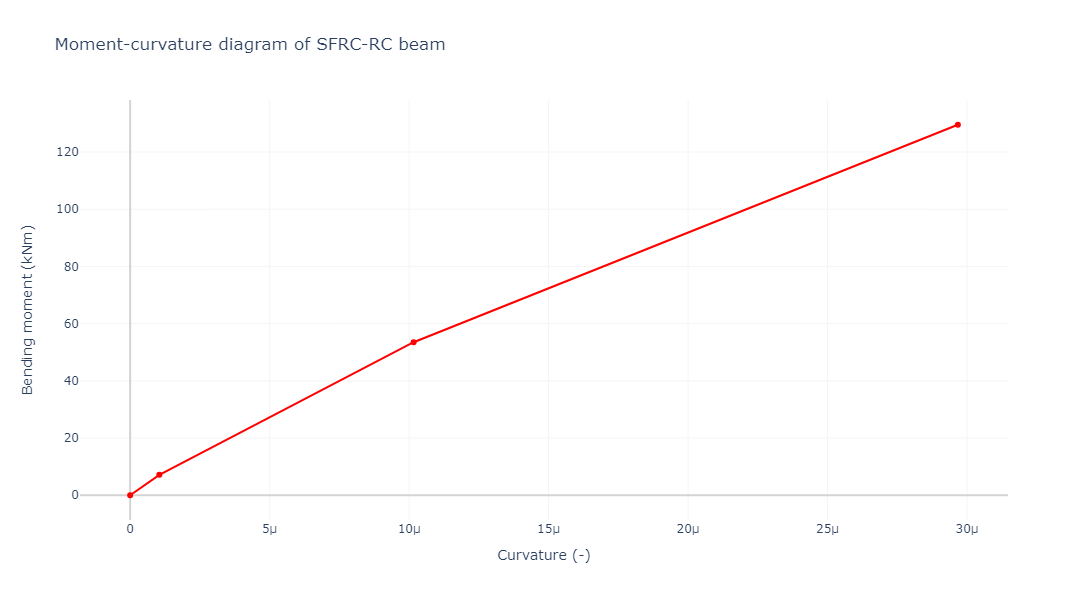

In [54]:
fig = go.Figure(data=[go.Scatter(x=[0,phicr, phiy, phiult], y=[0, Mcr, My, Mult])])
fig.data[0].marker.color = 'Red'
fig.layout.title.text = "Moment-curvature diagram of SFRC-RC beam"
fig.layout.width = 900
fig.layout.height = 600
fig.layout.xaxis.title = "Curvature (-)"
fig.layout.yaxis.title = "Bending moment (kNm)"
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGray', range=[0, None])
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='LightGray', range=[0, None])
fig.update_layout(
    plot_bgcolor='white',
    xaxis_showgrid=True, xaxis_gridcolor='rgb(245, 245, 245)',
    yaxis_showgrid=True, yaxis_gridcolor='rgb(245, 245, 245)')
fig.show()

In [55]:
import SFRC

In [56]:
SFRC.momentcurvatureSFRC(fc= 28, daggmax= 16, fy = 400, As= 226, rhof = 1, Vf = 0.005, df = 0.55, lf = 35, b = 120, d = 435, h = 500)

[[14.814046800000003, 45.86742947733356, 47.284680767146064],
 [5.427696788461228e-07, 1.2845129554804879e-05, 7.747070291263787e-05]]